### LSTM

In [1]:
# !pip install mido

In [2]:
# !pip install keras
# import keras

In [3]:
# Library to process MIDI files
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [4]:
import mido
from mido import MidiFile, MidiTrack, Message

In [5]:
import os

folder_name = '1-Calming'
keyword = 'A Presence Felt'
for fname in os.listdir('midi/'+folder_name):
    if keyword in fname:
        print(fname, "has the keyword")

ES_A Presence Felt - Gavin Luke.mp3.mid has the keyword


In [6]:
# define which song we are using
folder_name = '1-Calming'
song_name = 'ES_A Presence Felt - Gavin Luke'
midi_filename = 'midi/' + folder_name + '/' + song_name + '.mp3.mid'

midi = MidiFile(midi_filename)

cnt = 0
for msg in midi:
  print(msg)
  cnt+=1
  if cnt>100:
    break 

<meta message set_tempo tempo=500000 time=0>
program_change channel=0 program=0 time=0
note_on channel=0 note=76 velocity=14 time=0
note_on channel=0 note=57 velocity=50 time=0.010869565217391304
note_off channel=0 note=76 velocity=64 time=0.2934782608695652
note_on channel=0 note=72 velocity=24 time=0.08695652173913043
note_on channel=0 note=60 velocity=42 time=0.021739130434782608
note_off channel=0 note=57 velocity=64 time=0.021739130434782608
note_off channel=0 note=60 velocity=64 time=0.021739130434782608
note_on channel=0 note=57 velocity=38 time=0.010869565217391304
note_off channel=0 note=57 velocity=64 time=0.10869565217391304
note_on channel=0 note=57 velocity=33 time=0.010869565217391304
note_off channel=0 note=57 velocity=64 time=0.10869565217391304
note_on channel=0 note=57 velocity=29 time=0.010869565217391304
note_on channel=0 note=60 velocity=29 time=0.06521739130434782
note_off channel=0 note=57 velocity=64 time=0.010869565217391304
note_on channel=0 note=64 velocity=3

In [43]:
# save notes for the song as a list

notes = []
for msg in midi:
    if not msg.is_meta and msg.channel == 0 and msg.type == 'note_on':
        data = msg.bytes()
        notes.append(data[1]) # we are just adding the note!
        
print(notes[:15])
print(len(notes))

[76, 57, 72, 60, 57, 57, 57, 60, 64, 57, 57, 57, 57, 60, 60]
3226


In [44]:
## rescale all the notes to the [0,1] interval

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(np.array(notes).reshape(-1,1))
notes = list(scaler.transform(np.array(notes).reshape(-1,1)))

print(notes[:15])
print(len(notes))

[array([0.61016949]), array([0.28813559]), array([0.54237288]), array([0.33898305]), array([0.28813559]), array([0.28813559]), array([0.28813559]), array([0.33898305]), array([0.40677966]), array([0.28813559]), array([0.28813559]), array([0.28813559]), array([0.28813559]), array([0.33898305]), array([0.33898305])]
3226


In [11]:
# predict the next note for the a song sequence

# LSTM layers requires that data must have a certain shape
notes = [list(note) for note in notes]

# subsample data for training and prediction
X = []
y = []
# number of notes in a batch
n_prev = 30
for i in range(len(notes)-n_prev):
    X.append(notes[i:i+n_prev])
    y.append(notes[i+n_prev])
# save a seed to do prediction later
X_test = X[-300:]
y_test = y[-300:]
y_test = [note[0] for note in y_test]
X = X[:-300]
y = y[:-300]

print(len(X))

2196


In [12]:
np.shape(X)

(2196, 30, 1)

In [13]:
np.shape(y)

(2196, 1)

In [14]:
n_prev

30

In [15]:
# Define a model

model = Sequential()
model.add(LSTM(256, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, input_shape=(n_prev, 1), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.001)
model.compile(loss='mse', optimizer=optimizer)

# train model
model.fit(np.array(X), np.array(y), 
          32, 20, verbose=1)#, callbacks=[model_save_callback])

Train on 2196 samples
Epoch 1/20
2196/2196 [==============================] - 56s 25ms/sample - loss: 0.0488
Epoch 2/20
2196/2196 [==============================] - 25s 11ms/sample - loss: 0.0471
Epoch 3/20
2196/2196 [==============================] - 27s 12ms/sample - loss: 0.0463
Epoch 4/20
2196/2196 [==============================] - 42s 19ms/sample - loss: 0.0463
Epoch 5/20
2196/2196 [==============================] - 46s 21ms/sample - loss: 0.0459
Epoch 6/20
2196/2196 [==============================] - 45s 21ms/sample - loss: 0.0457
Epoch 7/20
2196/2196 [==============================] - 37s 17ms/sample - loss: 0.0453
Epoch 8/20
2196/2196 [==============================] - 25s 11ms/sample - loss: 0.0452
Epoch 9/20
2196/2196 [==============================] - 23s 11ms/sample - loss: 0.0451
Epoch 10/20
2196/2196 [==============================] - 23s 10ms/sample - loss: 0.0449
Epoch 11/20
2196/2196 [==============================] - 23s 10ms/sample - loss: 0.0449
Epoch 12/20
2196/21

In [16]:
# predict notes from test sequence

def get_pred(model, X_test, y_test):
    pred_test = model.predict(np.array(X_test))
    pred = np.squeeze(pred_test)
    pred_test = [note[0] for note in pred_test]
    pred = np.squeeze(scaler.inverse_transform(pred.reshape(-1,1)))
    pred_note = [int(i) for i in pred]
    
    mse = mean_squared_error(pred_test, y_test)

    return pred_test, pred_note, mse

pred_test, pred_note, mse = get_pred(model, X_test, y_test)
# pred_test, pred_note, mse = get_pred(model, X, y)

In [17]:
# mean squared error for prediction
print(mse)

0.034150538594568874


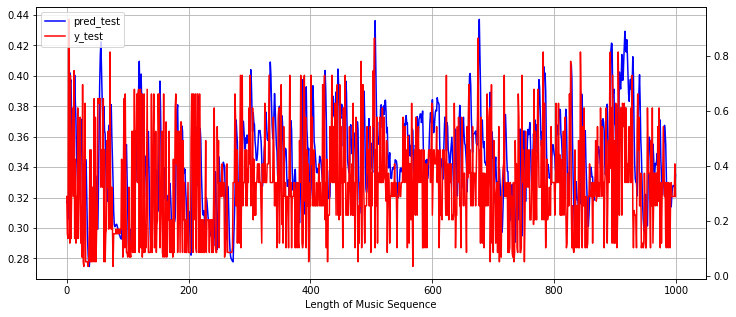

In [18]:
# plot the sequences generated

def plot_pred_seq(pred_test, y_test):

    df = pd.DataFrame({'pred_test': pred_test, 'y_test': y_test})

    plt.figure(figsize=(12,5))
    plt.xlabel('Length of Music Sequence')

    ax1 = df.pred_test.plot(color='blue', grid=True, label='pred_test')
    ax2 = df.y_test.plot(color='red', grid=True, secondary_y=True, label='y_test')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()


    plt.legend(h1+h2, l1+l2, loc=2)
    plt.show()
    
plot_pred_seq(pred_test, y_test)
# plot_pred_seq(pred_test, [note[0] for note in y])

In [19]:
# generate midi files
mid = MidiFile()
track = MidiTrack()
t = 0
for note in pred_note:
    # 147 means note_on
    # 67 is velocity
    note = np.asarray([147, note, 127]) 
    bytes = note.astype(int)
    msg = Message.from_bytes(bytes[0:3])
    t += 1
    msg.time = t
    track.append(msg)
    
mid.tracks.append(track)

mid.save('midi_generated/' + folder_name + '/' + song_name + '_gen.mid')

In [20]:
midi_filename

'midi/1-Calming/ES_A Presence Felt - Gavin Luke.mp3.mid'

In [21]:
## bidirectional lstm

In [22]:
# model_bi = Sequential()
# model_bi.add(Bidirectional(LSTM(256, return_sequences=True),input_shape=(n_prev, 1)))
# model_bi.add(Dropout(0.3))
# model_bi.add(Bidirectional(LSTM(128, return_sequences=True), 
#                         input_shape=(n_prev, 1)))
# model_bi.add(Dropout(0.3))
# model_bi.add(Bidirectional(LSTM(64, return_sequences=True), 
#                         input_shape=(n_prev, 1)))
# model_bi.add(Dropout(0.3))
# model_bi.add(Dense(1))
# model_bi.add(Activation('sigmoid'))

# optimizer = Adam(lr=0.001)
# model_bi.compile(loss='mse', optimizer=optimizer)

# # train model
# model_bi.fit(np.array(X), np.array(y), 
#           32, 20, verbose=1)#, callbacks=[model_save_callback])

In [34]:
# pred_test, pred_note, mse = get_pred(model_bi, X_test, y_test)
# print('MSE: ', mse)
# plot_pred_seq(pred_test, y_test)

In [35]:
song_dict.keys()

dict_keys(['1-Calming', '2-Sports', '3-Mysterious', '4-Nostalgia', '5-Happy'])

In [9]:
df_X = pd.read_csv('df_X.csv')
df_X = df_X.fillna(0)

df_X.shape

df_y = pd.read_csv('df_y.csv')
df_y.shape

(50, 44841)

ES_Big Sky - Gavin Luke.mp3.mid
Train on 2718 samples
Epoch 1/20
2718/2718 [==============================] - 47s 17ms/sample - loss: 0.0391
Epoch 2/20
2718/2718 [==============================] - 32s 12ms/sample - loss: 0.0381
Epoch 3/20
2718/2718 [==============================] - 32s 12ms/sample - loss: 0.0373
Epoch 4/20
2718/2718 [==============================] - 33s 12ms/sample - loss: 0.0369
Epoch 5/20
2718/2718 [==============================] - 32s 12ms/sample - loss: 0.0364
Epoch 6/20
2718/2718 [==============================] - 47s 17ms/sample - loss: 0.0362
Epoch 7/20
2718/2718 [==============================] - 44s 16ms/sample - loss: 0.0362
Epoch 8/20
2718/2718 [==============================] - 45s 17ms/sample - loss: 0.0363
Epoch 9/20
2718/2718 [==============================] - 47s 17ms/sample - loss: 0.0364
Epoch 10/20
2718/2718 [==============================] - 46s 17ms/sample - loss: 0.0361
Epoch 11/20
2718/2718 [==============================] - 96s 36ms/sample - 

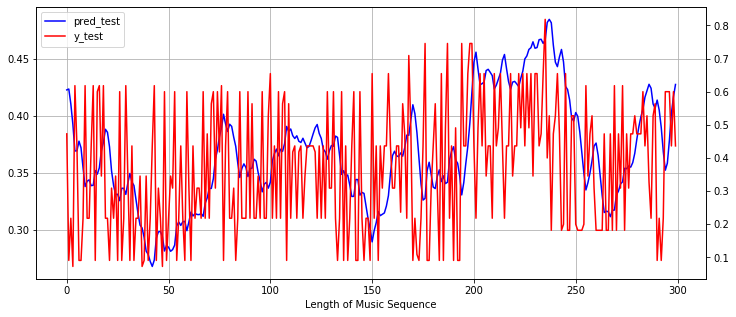

ES_The Crossing - Gavin Luke.mp3.mid
Train on 4695 samples
Epoch 1/20
4695/4695 [==============================] - 124s 26ms/sample - loss: 0.0381
Epoch 2/20
4695/4695 [==============================] - 80s 17ms/sample - loss: 0.0373
Epoch 3/20
4695/4695 [==============================] - 73s 16ms/sample - loss: 0.0371
Epoch 4/20
4695/4695 [==============================] - 81s 17ms/sample - loss: 0.0373
Epoch 5/20
4695/4695 [==============================] - 59s 13ms/sample - loss: 0.0370
Epoch 6/20
4695/4695 [==============================] - 65s 14ms/sample - loss: 0.0369
Epoch 7/20
4695/4695 [==============================] - 71s 15ms/sample - loss: 0.0370
Epoch 8/20
4695/4695 [==============================] - 87s 18ms/sample - loss: 0.0367
Epoch 9/20
4695/4695 [==============================] - 78s 17ms/sample - loss: 0.0367
Epoch 10/20
4695/4695 [==============================] - 64s 14ms/sample - loss: 0.0366
Epoch 11/20
4695/4695 [==============================] - 87s 19ms/sam

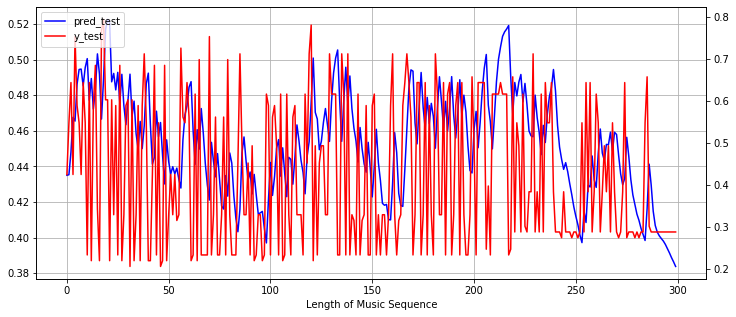

ES_Maybe Another Day - Spectacles Wallet and Watch.mp3.mid
Train on 3776 samples
Epoch 1/20
3776/3776 [==============================] - 92s 24ms/sample - loss: 0.0610
Epoch 2/20
3776/3776 [==============================] - 56s 15ms/sample - loss: 0.0604
Epoch 3/20
3776/3776 [==============================] - 63s 17ms/sample - loss: 0.0602
Epoch 4/20
3776/3776 [==============================] - 83s 22ms/sample - loss: 0.0597
Epoch 5/20
3776/3776 [==============================] - 75s 20ms/sample - loss: 0.0596
Epoch 6/20
3776/3776 [==============================] - 186s 49ms/sample - loss: 0.0597
Epoch 7/20
3776/3776 [==============================] - 186s 49ms/sample - loss: 0.0590
Epoch 8/20
3776/3776 [==============================] - 98s 26ms/sample - loss: 0.0595
Epoch 9/20
3776/3776 [==============================] - 52s 14ms/sample - loss: 0.0592
Epoch 10/20
3776/3776 [==============================] - 51s 14ms/sample - loss: 0.0589
Epoch 11/20
3776/3776 [=======================

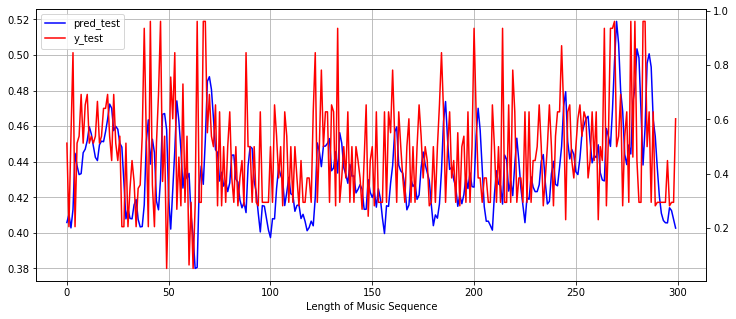

ES_No Good Byes - Amaranth Cove.mp3.mid
Train on 5299 samples
Epoch 1/20
5299/5299 [==============================] - 77s 15ms/sample - loss: 0.0357
Epoch 2/20
5299/5299 [==============================] - 62s 12ms/sample - loss: 0.0347
Epoch 3/20
5299/5299 [==============================] - 59s 11ms/sample - loss: 0.0346
Epoch 4/20
5299/5299 [==============================] - 62s 12ms/sample - loss: 0.0344
Epoch 5/20
5299/5299 [==============================] - 59s 11ms/sample - loss: 0.0342
Epoch 6/20
5299/5299 [==============================] - 72s 14ms/sample - loss: 0.0341
Epoch 7/20
5299/5299 [==============================] - 61s 12ms/sample - loss: 0.0340
Epoch 8/20
5299/5299 [==============================] - 60s 11ms/sample - loss: 0.0340
Epoch 9/20
5299/5299 [==============================] - 63s 12ms/sample - loss: 0.0340
Epoch 10/20
5299/5299 [==============================] - 61s 12ms/sample - loss: 0.0340
Epoch 11/20
5299/5299 [==============================] - 62s 12ms/s

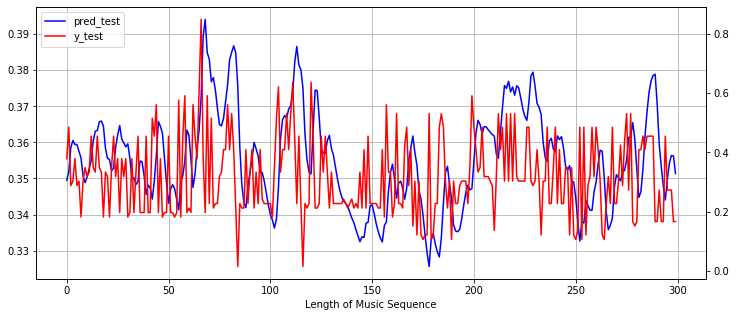

ES_A Presence Felt - Gavin Luke.mp3.mid
Train on 3194 samples
Epoch 1/20
3194/3194 [==============================] - 61s 19ms/sample - loss: 0.0459
Epoch 2/20
3194/3194 [==============================] - 37s 12ms/sample - loss: 0.0444
Epoch 3/20
3194/3194 [==============================] - 36s 11ms/sample - loss: 0.0439
Epoch 4/20
3194/3194 [==============================] - 46s 14ms/sample - loss: 0.0439
Epoch 5/20
3194/3194 [==============================] - 52s 16ms/sample - loss: 0.0434
Epoch 6/20
3194/3194 [==============================] - 38s 12ms/sample - loss: 0.0435
Epoch 7/20
3194/3194 [==============================] - 38s 12ms/sample - loss: 0.0432
Epoch 8/20
3194/3194 [==============================] - 45s 14ms/sample - loss: 0.0432
Epoch 9/20
3194/3194 [==============================] - 40s 12ms/sample - loss: 0.0429
Epoch 10/20
3194/3194 [==============================] - 36s 11ms/sample - loss: 0.0430
Epoch 11/20
3194/3194 [==============================] - 37s 11ms/s

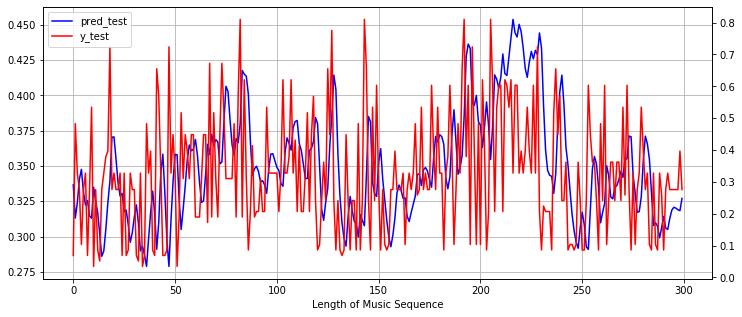

ES_Awash - Gavin Luke.mp3.mid
Train on 10436 samples
Epoch 1/20
10436/10436 [==============================] - 143s 14ms/sample - loss: 0.0498
Epoch 2/20
10436/10436 [==============================] - 118s 11ms/sample - loss: 0.0463
Epoch 3/20
10436/10436 [==============================] - 141s 13ms/sample - loss: 0.0463
Epoch 4/20
10436/10436 [==============================] - 143s 14ms/sample - loss: 0.0464
Epoch 5/20
10436/10436 [==============================] - 124s 12ms/sample - loss: 0.0461
Epoch 6/20
10436/10436 [==============================] - 137s 13ms/sample - loss: 0.0462
Epoch 7/20
10436/10436 [==============================] - 150s 14ms/sample - loss: 0.0461
Epoch 8/20
10436/10436 [==============================] - 162s 16ms/sample - loss: 0.0460
Epoch 9/20
10436/10436 [==============================] - 144s 14ms/sample - loss: 0.0460
Epoch 10/20
10436/10436 [==============================] - 139s 13ms/sample - loss: 0.0461
Epoch 11/20
10436/10436 [=====================

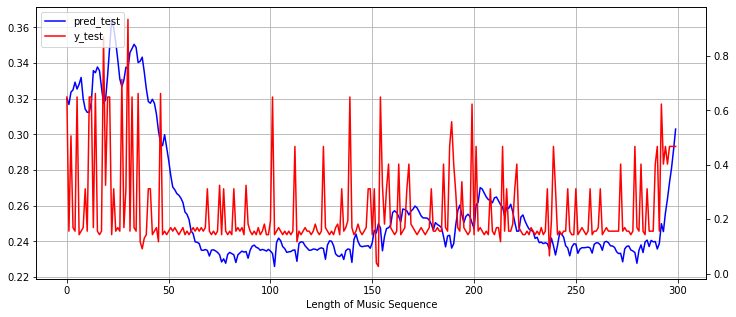

ES_A Whisper In The Dark - Gavin Luke.mp3.mid
Train on 4534 samples
Epoch 1/20
4534/4534 [==============================] - 87s 19ms/sample - loss: 0.0323
Epoch 2/20
4534/4534 [==============================] - 54s 12ms/sample - loss: 0.0318
Epoch 3/20
4534/4534 [==============================] - 63s 14ms/sample - loss: 0.0319
Epoch 4/20
4534/4534 [==============================] - 59s 13ms/sample - loss: 0.0315
Epoch 5/20
4534/4534 [==============================] - 62s 14ms/sample - loss: 0.0315
Epoch 6/20
4534/4534 [==============================] - 55s 12ms/sample - loss: 0.0314
Epoch 7/20
4534/4534 [==============================] - 60s 13ms/sample - loss: 0.0313
Epoch 8/20
4534/4534 [==============================] - 60s 13ms/sample - loss: 0.0311
Epoch 9/20
4534/4534 [==============================] - 55s 12ms/sample - loss: 0.0311
Epoch 10/20
4534/4534 [==============================] - 54s 12ms/sample - loss: 0.0310
Epoch 11/20
4534/4534 [==============================] - 53s 

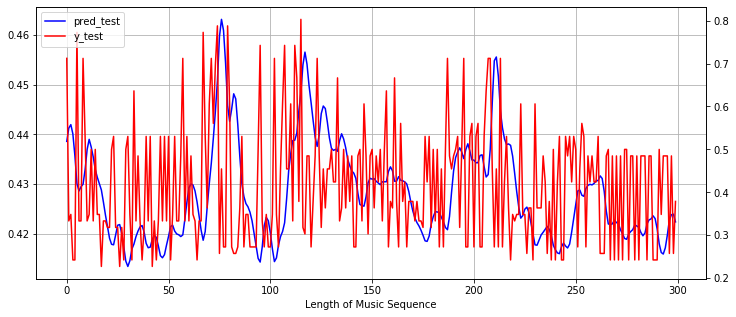

ES_Onthou - Ever So Blue.mp3.mid
Train on 1789 samples
Epoch 1/20
1789/1789 [==============================] - 51s 29ms/sample - loss: 0.0463
Epoch 2/20
1789/1789 [==============================] - 21s 12ms/sample - loss: 0.0444
Epoch 3/20
1789/1789 [==============================] - 21s 12ms/sample - loss: 0.0446
Epoch 4/20
1789/1789 [==============================] - 22s 12ms/sample - loss: 0.0444
Epoch 5/20
1789/1789 [==============================] - 21s 12ms/sample - loss: 0.0442
Epoch 6/20
1789/1789 [==============================] - 24s 13ms/sample - loss: 0.0446
Epoch 7/20
1789/1789 [==============================] - 23s 13ms/sample - loss: 0.0443
Epoch 8/20
1789/1789 [==============================] - 24s 14ms/sample - loss: 0.0441
Epoch 9/20
1789/1789 [==============================] - 22s 12ms/sample - loss: 0.0440
Epoch 10/20
1789/1789 [==============================] - 28s 16ms/sample - loss: 0.0441
Epoch 11/20
1789/1789 [==============================] - 24s 13ms/sample -

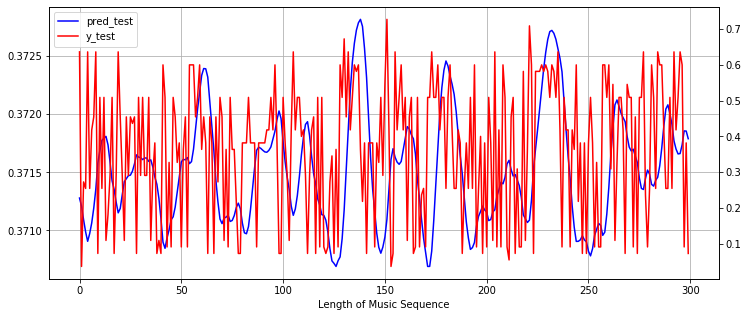

ES_The Human Derivative - Amaranth Cove.mp3.mid
Train on 4724 samples
Epoch 1/20
4724/4724 [==============================] - 90s 19ms/sample - loss: 0.0438
Epoch 2/20
4724/4724 [==============================] - 70s 15ms/sample - loss: 0.0399
Epoch 3/20
4724/4724 [==============================] - 72s 15ms/sample - loss: 0.0388
Epoch 4/20
4724/4724 [==============================] - 67s 14ms/sample - loss: 0.0385
Epoch 5/20
4724/4724 [==============================] - 62s 13ms/sample - loss: 0.0386
Epoch 6/20
4724/4724 [==============================] - 64s 14ms/sample - loss: 0.0385
Epoch 7/20
4724/4724 [==============================] - 62s 13ms/sample - loss: 0.0380
Epoch 8/20
4724/4724 [==============================] - 67s 14ms/sample - loss: 0.0383
Epoch 9/20
4724/4724 [==============================] - 64s 14ms/sample - loss: 0.0382
Epoch 10/20
4724/4724 [==============================] - 58s 12ms/sample - loss: 0.0383
Epoch 11/20
4724/4724 [==============================] - 59

In [ ]:
### Everything ###

import os
song_dict = {}
music_list = pd.read_csv('music_list.csv')
for folder_name in music_list.columns:
#     print(folder_name, '\n')
    song_dict[folder_name] = []
    for fname in os.listdir('midi/'+folder_name):
#         print('fname: ', fname)
        song_dict[folder_name].append(fname)

# print(song_dict['1-Calming'])

# for i_notes in range(df_X.shape[0]):
    
#     folder_name = df_y.iloc[i_notes,:].tolist()[0]
#     song_name = song_dict
i_notes = 0
for folder_name in song_dict.keys():
    for song_name in song_dict[folder_name]:
        if song_name != '.DS_Store':
            print(song_name)
            
            notes = df_X.iloc[i_notes, :].tolist()
            notes = [note for note in notes if note !=0]

            scaler = MinMaxScaler(feature_range=(0,1))
            scaler.fit(np.array(notes).reshape(-1,1))
            notes = list(scaler.transform(np.array(notes).reshape(-1,1)))
            
            
            
#             print(notes)
        #     print(notes)
            # predict the next note for the a song sequence

            # LSTM layers requires that data must have a certain shape
            notes = [list(note) for note in notes]

            # subsample data for training and prediction
            X = []
            y = []
            # number of notes in a batch
            n_prev = 30
            for i in range(len(notes)-n_prev):
                X.append(notes[i:i+n_prev])
                y.append(notes[i+n_prev])
            # save a seed to do prediction later
            X_test = X[-300:]
            y_test = y[-300:]
            y_test = [note[0] for note in y_test]
            X_train = X[:-300]
            y_train = y[:-300]

            ########
            # Define a model
            ########
            model = Sequential()
            model.add(LSTM(256, input_shape=(n_prev, 1), return_sequences=True))
            model.add(Dropout(0.3))
            model.add(LSTM(128, input_shape=(n_prev, 1), return_sequences=True))
            model.add(Dropout(0.3))
            model.add(LSTM(64, input_shape=(n_prev, 1), return_sequences=False))
            model.add(Dropout(0.3))
            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            optimizer = Adam(lr=0.001)
            model.compile(loss='mse', optimizer=optimizer)

            # train model
            model.fit(np.array(X), np.array(y), 
                      32, 20, verbose=1)#, callbacks=[model_save_callback])
            pred_test, pred_note, mse = get_pred(model, X_test, y_test)

            plot_pred_seq(pred_test, y_test)

            # generate midi files
            mid = MidiFile()
            track = MidiTrack()
            t = 0
            for note in pred_note:
                # 147 means note_on
                # 67 is velocity
                note = np.asarray([147, note, 127]) 
                bytes = note.astype(int)
                msg = Message.from_bytes(bytes[0:3])
                t += 1
                msg.time = t
                track.append(msg)

            mid.tracks.append(track)

            mid.save('midi_generated/' + folder_name + '/' + song_name + '_gen.mid')

            i_notes += 1

### MusicVAE